I'm working on implementing the generative model here

In [1]:
import torch
import pennylane as qml
from itertools import combinations
import matplotlib.pyplot as plt
from time_series_utils import generate_normal_time_series_set, plot_series

In [2]:
def D(gamma: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a k-local Walsh operator
    expansion. Here, k-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

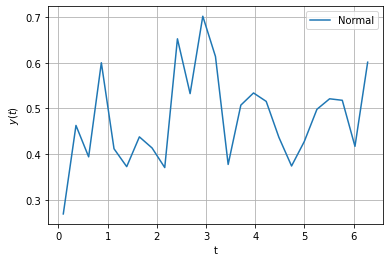

In [3]:
series_length = 5
n_qubits = series_length
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
X_norm, T_norm = generate_normal_time_series_set(25, 25, 0.1, 0.1, 2 * torch.pi)
plot_series(T_norm, X_norm)
# Make time series discrete using SAX


In [ ]:
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    k: int,
    W: callable,
    D: callable,
    n_qubits: int,
    measurement: str
) -> torch.Tensor:
    """Measure the probabilities for measuring each bitstring after applying a
    circuit of the form W†DWU to the |0⟩^(⊗n) state. This
    function is defined for individual sequence elements xt.
    """
    #qml.AngleEmbedding(xt, wires=range(n_qubits))
    
    # Depending on the dimensionality of the input, 
    # we need to embed the time series data
    # into different subspace
    for i, point in enumerate(xt):
        qml.BasisEmbedding(point, wires=[i])
    
    # These gates operate on the entire circuit: both system and evironment
    W(alpha, wires=range(n_qubits))
    D(gamma * t, n_qubits, k)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    
    if measurement == "probs":
        return qml.probs(range(n_qubits))
    elif measurement == "density_matrix":
        return qml.density_matrix(range(n_qubits))
    elif measurement == "state":
        return qml.state()

In [ ]:
def expectation_value(
    circuit: callable,
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    projector: int,
    n_samples: int,
    k: int,
    U: callable,
    W: callable,
) -> torch.Tensor:
    gammas = sigma.abs() * torch.randn((n_samples, gamma_length)) + mu
    expectation = torch.empty(n_samples)
    for i, gamma in enumerate(gammas):
        expectation[i] = circuit(xt, t, alpha, gamma, k, U, W, D, n_qubits)[projector] #callable_proj(xt, t, alpha, gamma)
    return expectation.mean()